cosmic(shower)muonveto efficiency

**TODO**

In [1]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import awkward
from uproot_methods import TLorentzVectorArray
from FireHydrant.Tools.trigger import Triggers

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import os
from os.path import join

dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2.json')))

In [3]:
class filterProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        cut_axis = hist.Bin('cut', 'passing Filter', 2, 0, 2)
        self._accumulator = processor.dict_accumulator({
            'filterResult': hist.Hist('Events', dataset_axis, cut_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        output['filterResult'].fill(dataset=dataset, cut=df['cosmicveto_result'].astype(int))
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3 cm

In [5]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=filterProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:02<00:00,  9.97items/s]


In [6]:
from collections import defaultdict

res = defaultdict(dict)
h = output['filterResult']
for d in h.identifiers('dataset'):
    res[str(d)]['total'] = h.integrate('dataset', d).integrate('cut').values()[()]
    res[str(d)]['passed']= h.integrate('dataset', d).integrate('cut', slice(1,2)).values()[()]

import pandas as pd
df = pd.DataFrame(res).transpose()
df['eff %'] = df['passed']/df['total']*100
display(df)

,passed,total,eff %
2mu2e/mXX-1000_mA-0p25_lxy-0p3,42160.0,42163.0,99.992885
2mu2e/mXX-100_mA-5_lxy-0p3,15593.0,15599.0,99.961536
4mu/mXX-1000_mA-0p25_lxy-0p3,43876.0,43884.0,99.981770
4mu/mXX-100_mA-5_lxy-0p3,15559.0,15577.0,99.884445


- lxy: 300cm

In [8]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=filterProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:02<00:00,  9.97items/s]


In [9]:
from collections import defaultdict

res = defaultdict(dict)
h = output['filterResult']
for d in h.identifiers('dataset'):
    res[str(d)]['total'] = h.integrate('dataset', d).integrate('cut').values()[()]
    res[str(d)]['passed']= h.integrate('dataset', d).integrate('cut', slice(1,2)).values()[()]

import pandas as pd
df = pd.DataFrame(res).transpose()
df['eff %'] = df['passed']/df['total']*100
display(df)

,passed,total,eff %
2mu2e/mXX-1000_mA-0p25_lxy-300,31098.0,31099.0,99.996784
2mu2e/mXX-100_mA-5_lxy-300,10406.0,10407.0,99.990391
4mu/mXX-1000_mA-0p25_lxy-300,32828.0,32828.0,100.000000
4mu/mXX-100_mA-5_lxy-300,10238.0,10245.0,99.931674


In [3]:
class myprocessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        npair_axis = hist.Bin('npp', '# parallel pairs', 20, 0, 20)
        tdiff_axis = hist.Bin('tdiff', '$\Delta t$(upper-lower) ns', 100, -100, 100)

        self._accumulator = processor.dict_accumulator({
            'npair': hist.Hist('Events', dataset_axis, npair_axis),
            'dtdiff': hist.Hist('Events', dataset_axis, tdiff_axis),
            'rpcdiff': hist.Hist('Events', dataset_axis, tdiff_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        # triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        output['npair'].fill(dataset=dataset, npp=df['cosmicveto_parallelpairs'])
        output['dtdiff'].fill(dataset=dataset, tdiff=df['cosmicveto_paralleltimediffDT'].flatten())
        output['rpcdiff'].fill(dataset=dataset, tdiff=df['cosmicveto_paralleltimediffRPC'].flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=myprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  6.64items/s]


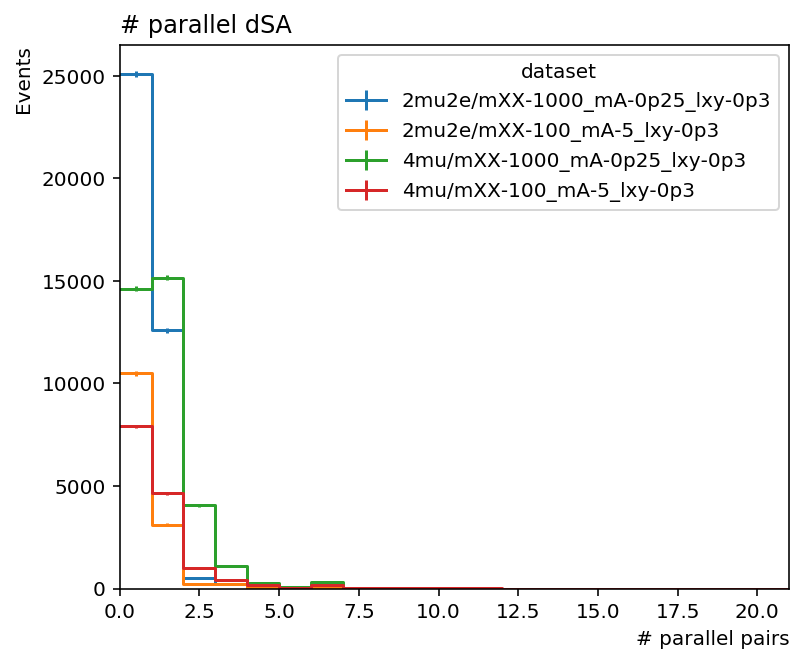

In [8]:
fig, ax=plt.subplots(1,1, figsize=(6,5))
hist.plot1d(output['npair'], overlay='dataset', overflow='over', ax=ax, density=False)
ax.set_title('# parallel dSA', x=0, ha='left')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

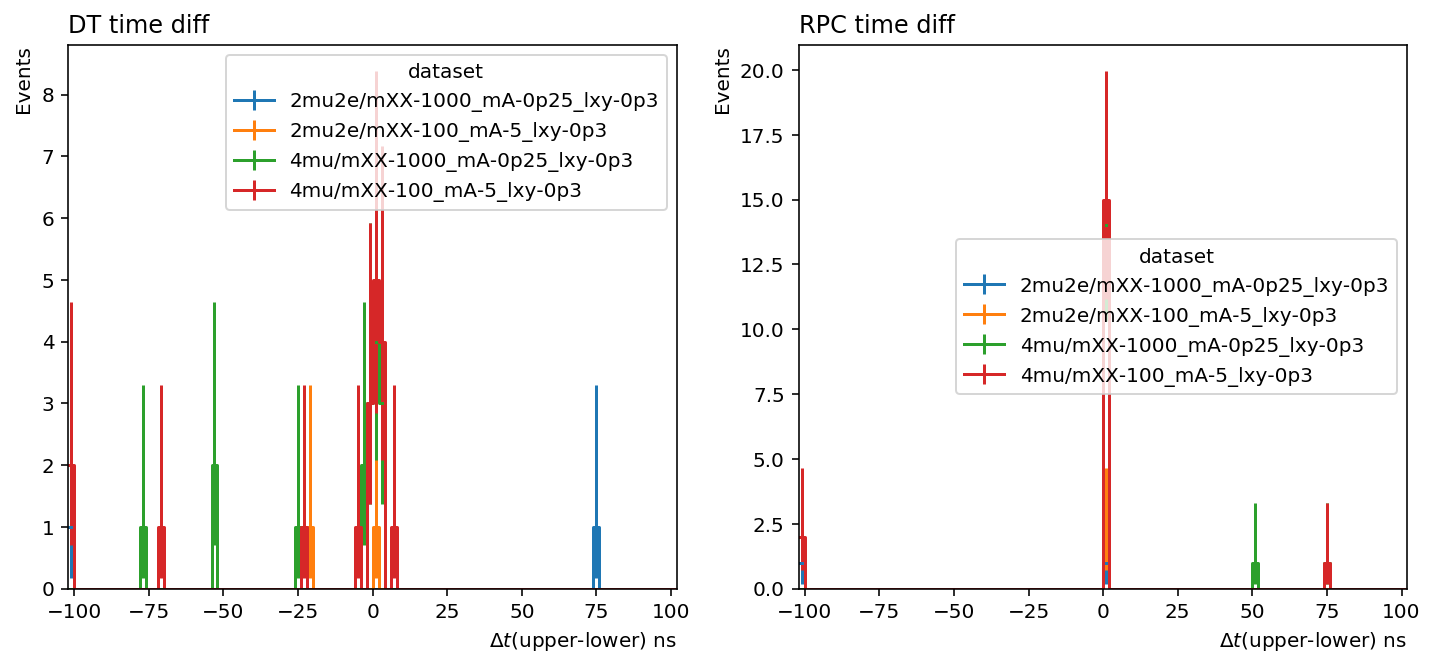

In [7]:
fig, axes=plt.subplots(1,2, figsize=(12,5))
hist.plot1d(output['dtdiff'], overlay='dataset', overflow='all', ax=axes[0])
hist.plot1d(output['rpcdiff'], overlay='dataset', overflow='all', ax=axes[1])

axes[0].set_title('DT time diff', x=0, ha='left')
axes[1].set_title('RPC time diff', x=0, ha='left')
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");